> # CS445 Project Task 2: Predicting Variation in Emotional Valence and Arousal over Time from Ecological Essays

# **Subtask #1**

## 1. Environment & Setup

In [90]:
!pip install -q transformers torch pandas scikit-learn

In [91]:
!pip install optuna

In [130]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import optuna
import torch
import torch.nn as nn
from torch.optim import AdamW

from transformers import (
    RobertaTokenizerFast,
    RobertaModel,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [131]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU name: NVIDIA A100-SXM4-40GB


## 2. Load & Inspect Dataset

In [95]:
# Load Subtask 1 dataset
DATA_PATH = "/content/train_subtask1.csv"  # update if needed

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (2764, 8)


,user_id,text_id,text,timestamp,collection_phase,is_words,valence,arousal
0,3,251,I ' ve been feeling just fine . Nice and relax...,2021-06-08 12:26:16,1,False,1.0,1.0
1,3,252,I ' ve been feeling pretty good . This is my l...,2021-06-09 13:41:40,1,False,0.0,1.0
2,3,253,Still feeling sick today and sneezing alot wit...,2021-06-11 15:13:48,1,False,1.0,1.0
3,3,254,I ' m still feeling kinda sickly but I powered...,2021-06-12 12:20:03,1,False,1.0,1.0
4,3,255,I ' m feeling so much better today ! Seems lik...,2021-06-13 14:54:41,1,False,2.0,1.0


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2764 non-null   int64  
 1   text_id           2764 non-null   int64  
 2   text              2764 non-null   object 
 3   timestamp         2764 non-null   object 
 4   collection_phase  2764 non-null   int64  
 5   is_words          2764 non-null   bool   
 6   valence           2764 non-null   float64
 7   arousal           2764 non-null   float64
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 154.0+ KB


In [97]:
num_users = df["user_id"].nunique()
texts_per_user = df.groupby("user_id").size()

print("Number of users:", num_users)
print("Texts per user (summary):")
texts_per_user.describe()


Number of users: 137
Texts per user (summary):


,0
count,137.000000
mean,20.175182
std,27.966602
min,2.000000
25%,7.000000
50%,14.000000
75%,20.000000
max,206.000000


In [98]:
is_words_counts = df["is_words"].value_counts()

print("is_words distribution:")
print(is_words_counts)
print("\nPercentage:")
print(is_words_counts / len(df) * 100)


is_words distribution:
is_words
True     1433
False    1331
Name: count, dtype: int64

Percentage:
is_words
True     51.845152
False    48.154848
Name: count, dtype: float64


In [99]:
df["text_length"] = df["text"].str.split().apply(len)

print("Text length statistics:")
df["text_length"].describe()


Text length statistics:


,text_length
count,2764.000000
mean,32.906295
std,31.350532
min,5.000000
25%,9.000000
50%,11.000000
75%,52.000000
max,225.000000


## 3. User-Level Train / Dev Split

In [100]:
# Get unique user IDs
users = df["user_id"].unique()
print("Total users:", len(users))

# Shuffle users (reproducible because seed is set)
np.random.shuffle(users)


Total users: 137


In [101]:
train_ratio = 0.8
num_train_users = int(len(users) * train_ratio)

train_users = users[:num_train_users]
dev_users = users[num_train_users:]

print("Train users:", len(train_users))
print("Dev users:", len(dev_users))


Train users: 109
Dev users: 28


In [102]:
train_df = df[df["user_id"].isin(train_users)].copy()
dev_df = df[df["user_id"].isin(dev_users)].copy()

print("Train set size:", train_df.shape)
print("Dev set size:", dev_df.shape)


Train set size: (2192, 9)
Dev set size: (572, 9)


In [103]:
# Sanity check: no overlapping users
overlap = set(train_df["user_id"]).intersection(set(dev_df["user_id"]))
print("Overlapping users:", len(overlap))


Overlapping users: 0


In [104]:
print("Train is_words distribution:")
print(train_df["is_words"].value_counts(normalize=True))

print("\nDev is_words distribution:")
print(dev_df["is_words"].value_counts(normalize=True))


Train is_words distribution:
is_words
False    0.511405
True     0.488595
Name: proportion, dtype: float64

Dev is_words distribution:
is_words
True     0.632867
False    0.367133
Name: proportion, dtype: float64


## 4. Preprocessing & Tokenization

In [105]:
def preprocess_text(text: str) -> str:
    # Minimal preprocessing only
    return text.lower().strip()

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)


In [106]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

MAX_LENGTH = 256


In [107]:
class AffectDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.texts = df["text"].tolist()
        self.is_words = df["is_words"].astype(int).tolist()
        self.labels = df[["valence", "arousal"]].values.astype("float32")
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "is_words": torch.tensor(self.is_words[idx], dtype=torch.float),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item


In [108]:
train_dataset = AffectDataset(train_df, tokenizer, MAX_LENGTH)
dev_dataset = AffectDataset(dev_df, tokenizer, MAX_LENGTH)

print("Train samples:", len(train_dataset))
print("Dev samples:", len(dev_dataset))


Train samples: 2192
Dev samples: 572


In [109]:
BATCH_SIZE = 16  # increase if GPU allows

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dev_loader = torch.utils.data.DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [110]:
batch = next(iter(train_loader))

for key, value in batch.items():
    print(key, value.shape)


input_ids torch.Size([16, 256])
attention_mask torch.Size([16, 256])
is_words torch.Size([16])
labels torch.Size([16, 2])


## 5. Define the Model

In [111]:
# 1. LOSS FUNCTION: Concordance Correlation Coefficient (CCC) Loss
class CCCLoss(nn.Module):
    def __init__(self, arousal_weight=1.0):
        super().__init__()
        self.arousal_weight = arousal_weight

    def ccc(self, preds, targets):
        mean_pred = torch.mean(preds)
        mean_target = torch.mean(targets)
        var_pred = torch.var(preds, unbiased=False)
        var_target = torch.var(targets, unbiased=False)
        cov = torch.mean((preds - mean_pred) * (targets - mean_target))

        numerator = 2 * cov
        denominator = var_pred + var_target + (mean_pred - mean_target)**2
        return 1.0 - (numerator / (denominator + 1e-8))

    def forward(self, preds, targets):
        val_loss = self.ccc(preds[:, 0], targets[:, 0])
        arl_loss = self.ccc(preds[:, 1], targets[:, 1])
        return val_loss + (self.arousal_weight * arl_loss)


In [125]:
class RobertaSplitHeadRegressor(nn.Module):
    def __init__(self, dropout_prob=0.1, freeze_layers=False):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")

        if freeze_layers:
            # Freeze Embeddings
            for param in self.roberta.embeddings.parameters():
                param.requires_grad = False

            # Freeze First 8 Layers of Encoder (0-7)
            for name, param in self.roberta.encoder.layer.named_parameters():
                # name format: "0.attention..." -> extract "0"
                layer_num = int(name.split(".")[0])
                if layer_num < 8:
                    param.requires_grad = False
        # ------------------------------

        hidden_size = self.roberta.config.hidden_size

        # Valence Head
        self.valence_head = nn.Sequential(
            nn.Linear(hidden_size + 1, 512),
            nn.BatchNorm1d(512), # Added Batch Norm
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 1)
        )
        # Arousal Head
        self.arousal_head = nn.Sequential(
            nn.Linear(hidden_size + 1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 1)
        )

    def forward(self, input_ids, attention_mask, is_words):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Mean Pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_embeddings = torch.sum(outputs.last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_pooling = sum_embeddings / sum_mask

        combined = torch.cat([mean_pooling, is_words.unsqueeze(1)], dim=1)

        val_pred = self.valence_head(combined)
        arl_pred = self.arousal_head(combined)
        return torch.cat([val_pred, arl_pred], dim=1)

In [113]:
def get_optimizer_grouped_parameters(model, learning_rate, weight_decay, layer_decay):
    opt_parameters = []
    named_parameters = list(model.named_parameters())
    head_params = ["valence_head", "arousal_head"]

    for name, param in named_parameters:
        if not param.requires_grad: continue

        lr = learning_rate
        if not any(h in name for h in head_params):
            if "encoder.layer" in name:
                layer_num = int(name.split("encoder.layer.")[1].split(".")[0])
                lr = learning_rate * (layer_decay ** (11 - layer_num))
            elif "embeddings" in name:
                lr = learning_rate * (layer_decay ** 12)

        opt_parameters.append({"params": param, "lr": lr, "weight_decay": weight_decay})

    return AdamW(opt_parameters)

## 6. Training Configuration & Training Loop

In [114]:
def calculate_leaderboard_score(preds, true_df):
    df = true_df.copy()
    target_cols = ['valence', 'arousal']

    df['pred_valence'] = preds[:, 0]
    df['pred_arousal'] = preds[:, 1]

    pred_cols = ['pred_valence', 'pred_arousal']

    scores = {}

    for i, label in enumerate(target_cols):
        t_col = label
        p_col = pred_cols[i]

        # 1. Between-User Correlation
        user_means = df.groupby('user_id')[[t_col, p_col]].mean()
        if len(user_means) > 1:
            r_between = user_means[t_col].corr(user_means[p_col])
        else:
            r_between = 0.0

        # 2. Within-User Correlation
        corrs = []
        for user_id, group in df.groupby('user_id'):
            if len(group) > 1 and group[t_col].std() > 0 and group[p_col].std() > 0:
                c = group[t_col].corr(group[p_col])
                corrs.append(c)
        r_within = np.mean(corrs) if corrs else 0.0

        # 3. Composite Correlation (Fisher Z-Transform)
        r_within = np.clip(r_within, -0.999, 0.999)
        r_between = np.clip(r_between, -0.999, 0.999)

        z_within = np.arctanh(r_within)
        z_between = np.arctanh(r_between)

        r_composite = np.tanh((z_within + z_between) / 2)
        scores[label] = r_composite

    avg_score = (scores['valence'] + scores['arousal']) / 2

    return avg_score, scores['valence'], scores['arousal']

In [127]:
def objective(trial):
    # --- HYPERPARAMETERS ---
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 8e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.2)
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.5) # Minimum 0.2 is safer
    arousal_weight = trial.suggest_float("arousal_weight", 2.0, 6.0) # Bias towards arousal
    layer_decay = trial.suggest_float("layer_decay", 0.85, 0.98)
    freeze_layers = trial.suggest_categorical("freeze_layers", [True, False])

    # --- MODEL SETUP ---
    model = RobertaSplitHeadRegressor(
        dropout_prob=dropout_prob,
        freeze_layers=freeze_layers
    ).to(device)

    optimizer = get_optimizer_grouped_parameters(model, learning_rate, weight_decay, layer_decay)
    criterion = CCCLoss(arousal_weight=arousal_weight)

    EPOCHS = 6
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

    best_composite_score = -1.0

    for epoch in range(EPOCHS):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            is_words = batch["is_words"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, is_words)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        preds_list = []
        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                is_words = batch["is_words"].to(device)
                outputs = model(input_ids, attention_mask, is_words)
                preds_list.append(outputs.cpu().numpy())

        preds = np.vstack(preds_list)

        # Calculate Score
        avg_score, _, _ = calculate_leaderboard_score(preds, dev_df)

        trial.report(avg_score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_score > best_composite_score:
            best_composite_score = avg_score

    return best_composite_score

In [128]:
print("Hyperparameter Tuning Staring Now...")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, timeout=20000)

print("\n------------------------------------------------")
print("Best Parameters:")
print(study.best_params)
print("------------------------------------------------")
print(f"Best Composite Score: {study.best_value:.4f}")

[I 2025-12-28 19:52:54,533] A new study created in memory with name: no-name-19aac35b-cd31-4f52-b7d6-159505882da1
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hyperparameter Tuning Staring Now...


[I 2025-12-28 19:54:17,112] Trial 0 finished with value: 0.6399777051970724 and parameters: {'learning_rate': 6.73483653326782e-05, 'weight_decay': 0.07303363933021327, 'dropout_prob': 0.3579441938101974, 'arousal_weight': 5.109705562697141, 'layer_decay': 0.9122074591859142, 'freeze_layers': True}. Best is trial 0 with value: 0.6399777051970724.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-28 19:55:39,614] Trial 1 finished with value: 0.63908116117885 and parameters: {'learning_rate': 2.1870065009166293e-05, 'weight_decay': 0.1502948418628263, 'dropout_prob': 0.3232504272299102, 'arousal_weight': 2.601163612547388, 'layer_decay': 0.9626431246156854, 'freeze_layers': True}. Best is trial 0 with value: 0.6399777051970724.
Some weights of RobertaModel


------------------------------------------------
Best Parameters:
{'learning_rate': 5.571619006606248e-05, 'weight_decay': 0.16486051061672102, 'dropout_prob': 0.2449578003882044, 'arousal_weight': 4.085917163852317, 'layer_decay': 0.9098192872956561, 'freeze_layers': False}
------------------------------------------------
Best Composite Score: 0.6853


In [129]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

best_params = study.best_params
print(f"Selected Best Parameters from Optuna: {best_params}")

dropout_prob = best_params.get('dropout_prob', 0.4)
learning_rate = best_params.get('learning_rate', 2e-5)
weight_decay = best_params.get('weight_decay', 0.1)
layer_decay = best_params.get('layer_decay', 0.95)
arousal_weight = best_params.get('arousal_weight', 4.0)
freeze_layers = best_params.get('freeze_layers', False) # True/False

fold_scores = []

full_dataset = AffectDataset(df, tokenizer, MAX_LENGTH)

print(f"\nStarting {N_FOLDS}-Fold Cross Validation (Final Training)...")

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*40}")
    print(f"FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*40}")

    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(full_dataset, batch_size=16, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(full_dataset, batch_size=16, sampler=val_subsampler)

    model = RobertaSplitHeadRegressor(
        dropout_prob=dropout_prob,
        freeze_layers=freeze_layers
    ).to(device)

    criterion = CCCLoss(arousal_weight=arousal_weight)
    optimizer = get_optimizer_grouped_parameters(model, learning_rate, weight_decay, layer_decay)

    EPOCHS_FOLD = 15
    total_steps = len(trainloader) * EPOCHS_FOLD
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

    best_fold_score = -1.0

    for epoch in range(EPOCHS_FOLD):
        # -- Train --
        model.train()
        total_loss = 0
        for batch in trainloader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            is_words = batch["is_words"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, is_words)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(trainloader)

        model.eval()
        preds_list = []
        labels_list = []
        with torch.no_grad():
            for batch in valloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                is_words = batch["is_words"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask, is_words)
                preds_list.append(outputs.cpu().numpy())
                labels_list.append(labels.cpu().numpy())

        preds = np.vstack(preds_list)
        trues = np.vstack(labels_list)

        # Calculate Simple Pearson R (for Valence and Arousal)
        from scipy.stats import pearsonr
        val_r, _ = pearsonr(trues[:, 0], preds[:, 0])
        arl_r, _ = pearsonr(trues[:, 1], preds[:, 1])
        avg_r = (val_r + arl_r) / 2

        print(f"  Epoch {epoch+1}: Loss={avg_train_loss:.4f} | Avg R={avg_r:.4f} (Val={val_r:.3f}, Arl={arl_r:.3f})")

        # Save the best model for this fold
        if avg_r > best_fold_score:
            best_fold_score = avg_r
            torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pt")

    print(f"Fold {fold+1} Finished. Best Score: {best_fold_score:.4f}")
    fold_scores.append(best_fold_score)

print(f"\n{'='*40}")
print("K-FOLD CROSS VALIDATION COMPLETED")
print(f"{'='*40}")
print(f"Fold Scores: {fold_scores}")
print(f"Average Score across 5 folds: {np.mean(fold_scores):.4f}")
print("Best models for each fold are saved as 'best_model_fold_X.pt'.")

Selected Best Parameters from Optuna: {'learning_rate': 5.571619006606248e-05, 'weight_decay': 0.16486051061672102, 'dropout_prob': 0.2449578003882044, 'arousal_weight': 4.085917163852317, 'layer_decay': 0.9098192872956561, 'freeze_layers': False}

Starting 5-Fold Cross Validation (Final Training)...

FOLD 1/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1: Loss=3.8840 | Avg R=0.5785 (Val=0.684, Arl=0.473)
  Epoch 2: Loss=2.6574 | Avg R=0.6033 (Val=0.675, Arl=0.532)
  Epoch 3: Loss=2.2963 | Avg R=0.6377 (Val=0.706, Arl=0.570)
  Epoch 4: Loss=1.8736 | Avg R=0.6404 (Val=0.723, Arl=0.557)
  Epoch 5: Loss=1.4829 | Avg R=0.6264 (Val=0.715, Arl=0.538)
  Epoch 6: Loss=1.3152 | Avg R=0.6578 (Val=0.728, Arl=0.588)
  Epoch 7: Loss=1.3097 | Avg R=0.6296 (Val=0.686, Arl=0.573)
  Epoch 8: Loss=1.0813 | Avg R=0.6230 (Val=0.690, Arl=0.556)
  Epoch 9: Loss=1.0104 | Avg R=0.6294 (Val=0.710, Arl=0.549)
  Epoch 10: Loss=0.8674 | Avg R=0.6337 (Val=0.700, Arl=0.567)
  Epoch 11: Loss=0.8146 | Avg R=0.6258 (Val=0.699, Arl=0.552)
  Epoch 12: Loss=0.7889 | Avg R=0.6415 (Val=0.708, Arl=0.575)
  Epoch 13: Loss=0.6796 | Avg R=0.6304 (Val=0.706, Arl=0.555)
  Epoch 14: Loss=0.6488 | Avg R=0.6260 (Val=0.703, Arl=0.549)
  Epoch 15: Loss=0.6415 | Avg R=0.6326 (Val=0.704, Arl=0.561)
Fold 1 Finished. Best Score: 0.6578

FOLD 2/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1: Loss=4.1377 | Avg R=0.5329 (Val=0.641, Arl=0.425)
  Epoch 2: Loss=2.8223 | Avg R=0.6033 (Val=0.683, Arl=0.523)
  Epoch 3: Loss=2.2140 | Avg R=0.6194 (Val=0.706, Arl=0.533)
  Epoch 4: Loss=1.8918 | Avg R=0.5954 (Val=0.702, Arl=0.489)
  Epoch 5: Loss=1.6187 | Avg R=0.6387 (Val=0.734, Arl=0.543)
  Epoch 6: Loss=1.4132 | Avg R=0.6417 (Val=0.736, Arl=0.548)
  Epoch 7: Loss=1.2222 | Avg R=0.6391 (Val=0.731, Arl=0.547)
  Epoch 8: Loss=1.0966 | Avg R=0.6270 (Val=0.726, Arl=0.528)
  Epoch 9: Loss=0.9956 | Avg R=0.6210 (Val=0.723, Arl=0.519)
  Epoch 10: Loss=0.9121 | Avg R=0.6282 (Val=0.725, Arl=0.532)
  Epoch 11: Loss=0.8309 | Avg R=0.6220 (Val=0.728, Arl=0.516)
  Epoch 12: Loss=0.7589 | Avg R=0.6107 (Val=0.722, Arl=0.499)
  Epoch 13: Loss=0.7343 | Avg R=0.6246 (Val=0.722, Arl=0.527)
  Epoch 14: Loss=0.7357 | Avg R=0.6240 (Val=0.723, Arl=0.525)
  Epoch 15: Loss=0.6600 | Avg R=0.6216 (Val=0.720, Arl=0.523)
Fold 2 Finished. Best Score: 0.6417

FOLD 3/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1: Loss=3.8074 | Avg R=0.5790 (Val=0.672, Arl=0.486)
  Epoch 2: Loss=2.5914 | Avg R=0.5729 (Val=0.672, Arl=0.474)
  Epoch 3: Loss=2.1400 | Avg R=0.6204 (Val=0.681, Arl=0.560)
  Epoch 4: Loss=1.8486 | Avg R=0.6262 (Val=0.702, Arl=0.550)
  Epoch 5: Loss=1.5503 | Avg R=0.6269 (Val=0.697, Arl=0.557)
  Epoch 6: Loss=1.5219 | Avg R=0.6151 (Val=0.676, Arl=0.554)
  Epoch 7: Loss=1.2362 | Avg R=0.6318 (Val=0.702, Arl=0.562)
  Epoch 8: Loss=1.1848 | Avg R=0.6322 (Val=0.705, Arl=0.560)
  Epoch 9: Loss=1.0510 | Avg R=0.6325 (Val=0.703, Arl=0.562)
  Epoch 10: Loss=0.9072 | Avg R=0.6239 (Val=0.694, Arl=0.554)
  Epoch 11: Loss=0.8639 | Avg R=0.6407 (Val=0.702, Arl=0.579)
  Epoch 12: Loss=0.8016 | Avg R=0.6287 (Val=0.697, Arl=0.560)
  Epoch 13: Loss=0.7816 | Avg R=0.6394 (Val=0.697, Arl=0.581)
  Epoch 14: Loss=0.7372 | Avg R=0.6311 (Val=0.694, Arl=0.568)
  Epoch 15: Loss=0.6838 | Avg R=0.6356 (Val=0.700, Arl=0.572)
Fold 3 Finished. Best Score: 0.6407

FOLD 4/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1: Loss=4.0433 | Avg R=0.5647 (Val=0.656, Arl=0.474)
  Epoch 2: Loss=2.8054 | Avg R=0.6009 (Val=0.685, Arl=0.517)
  Epoch 3: Loss=2.1797 | Avg R=0.6303 (Val=0.690, Arl=0.570)
  Epoch 4: Loss=1.8222 | Avg R=0.6283 (Val=0.711, Arl=0.546)
  Epoch 5: Loss=1.5762 | Avg R=0.6216 (Val=0.720, Arl=0.523)
  Epoch 6: Loss=1.3176 | Avg R=0.6101 (Val=0.708, Arl=0.513)
  Epoch 7: Loss=1.2562 | Avg R=0.6331 (Val=0.715, Arl=0.551)
  Epoch 8: Loss=1.1596 | Avg R=0.6281 (Val=0.720, Arl=0.536)
  Epoch 9: Loss=0.9774 | Avg R=0.6122 (Val=0.709, Arl=0.515)
  Epoch 10: Loss=0.8796 | Avg R=0.6253 (Val=0.710, Arl=0.541)
  Epoch 11: Loss=0.8287 | Avg R=0.6283 (Val=0.713, Arl=0.543)
  Epoch 12: Loss=0.8096 | Avg R=0.6210 (Val=0.714, Arl=0.528)
  Epoch 13: Loss=0.7014 | Avg R=0.6284 (Val=0.714, Arl=0.542)
  Epoch 14: Loss=0.6867 | Avg R=0.6311 (Val=0.715, Arl=0.547)
  Epoch 15: Loss=0.7017 | Avg R=0.6288 (Val=0.714, Arl=0.543)
Fold 4 Finished. Best Score: 0.6331

FOLD 5/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1: Loss=4.0231 | Avg R=0.5803 (Val=0.647, Arl=0.514)
  Epoch 2: Loss=2.6289 | Avg R=0.6137 (Val=0.685, Arl=0.542)
  Epoch 3: Loss=2.0782 | Avg R=0.6154 (Val=0.702, Arl=0.528)
  Epoch 4: Loss=1.7633 | Avg R=0.6293 (Val=0.718, Arl=0.540)
  Epoch 5: Loss=1.5387 | Avg R=0.6163 (Val=0.716, Arl=0.517)
  Epoch 6: Loss=1.3041 | Avg R=0.6451 (Val=0.735, Arl=0.555)
  Epoch 7: Loss=1.1927 | Avg R=0.6217 (Val=0.737, Arl=0.507)
  Epoch 8: Loss=1.0626 | Avg R=0.6370 (Val=0.730, Arl=0.544)
  Epoch 9: Loss=0.9961 | Avg R=0.6243 (Val=0.710, Arl=0.539)
  Epoch 10: Loss=0.8960 | Avg R=0.6225 (Val=0.705, Arl=0.540)
  Epoch 11: Loss=0.7696 | Avg R=0.6366 (Val=0.717, Arl=0.556)
  Epoch 12: Loss=0.7339 | Avg R=0.6266 (Val=0.717, Arl=0.536)
  Epoch 13: Loss=0.7016 | Avg R=0.6194 (Val=0.716, Arl=0.523)
  Epoch 14: Loss=0.6731 | Avg R=0.6189 (Val=0.715, Arl=0.522)
  Epoch 15: Loss=0.6559 | Avg R=0.6191 (Val=0.714, Arl=0.524)
Fold 5 Finished. Best Score: 0.6451

K-FOLD CROSS VALIDATION COMPLETED
Fold Sco

In [133]:
eval_loader = dev_loader

num_samples = len(eval_loader.dataset)
ensemble_preds = np.zeros((num_samples, 2))

for fold in range(1, N_FOLDS + 1):
    print(f"  -> Loading Model from Fold {fold}...")

    model = RobertaSplitHeadRegressor(
        dropout_prob=dropout_prob,
        freeze_layers=freeze_layers
    ).to(device)

    model.load_state_dict(torch.load(f"best_model_fold_{fold}.pt"))
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            is_words = batch["is_words"].to(device)

            outputs = model(input_ids, attention_mask, is_words)
            fold_preds.append(outputs.cpu().numpy())

    ensemble_preds += np.vstack(fold_preds)

ensemble_preds /= N_FOLDS


  -> Loading Model from Fold 1...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> Loading Model from Fold 2...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> Loading Model from Fold 3...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> Loading Model from Fold 4...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> Loading Model from Fold 5...


In [134]:
all_labels = []
with torch.no_grad():
    for batch in eval_loader:
        all_labels.append(batch["labels"].cpu().numpy())
trues = np.vstack(all_labels)

In [135]:
final_avg, final_val_score, final_arl_score = calculate_leaderboard_score(ensemble_preds, dev_df)

# B. Calculate MSE & MAE
val_mse = mean_squared_error(trues[:, 0], ensemble_preds[:, 0])
arl_mse = mean_squared_error(trues[:, 1], ensemble_preds[:, 1])
val_mae = mean_absolute_error(trues[:, 0], ensemble_preds[:, 0])
arl_mae = mean_absolute_error(trues[:, 1], ensemble_preds[:, 1])

# C. Global Pearson
global_val_corr, _ = pearsonr(trues[:, 0], ensemble_preds[:, 0])
global_arl_corr, _ = pearsonr(trues[:, 1], ensemble_preds[:, 1])


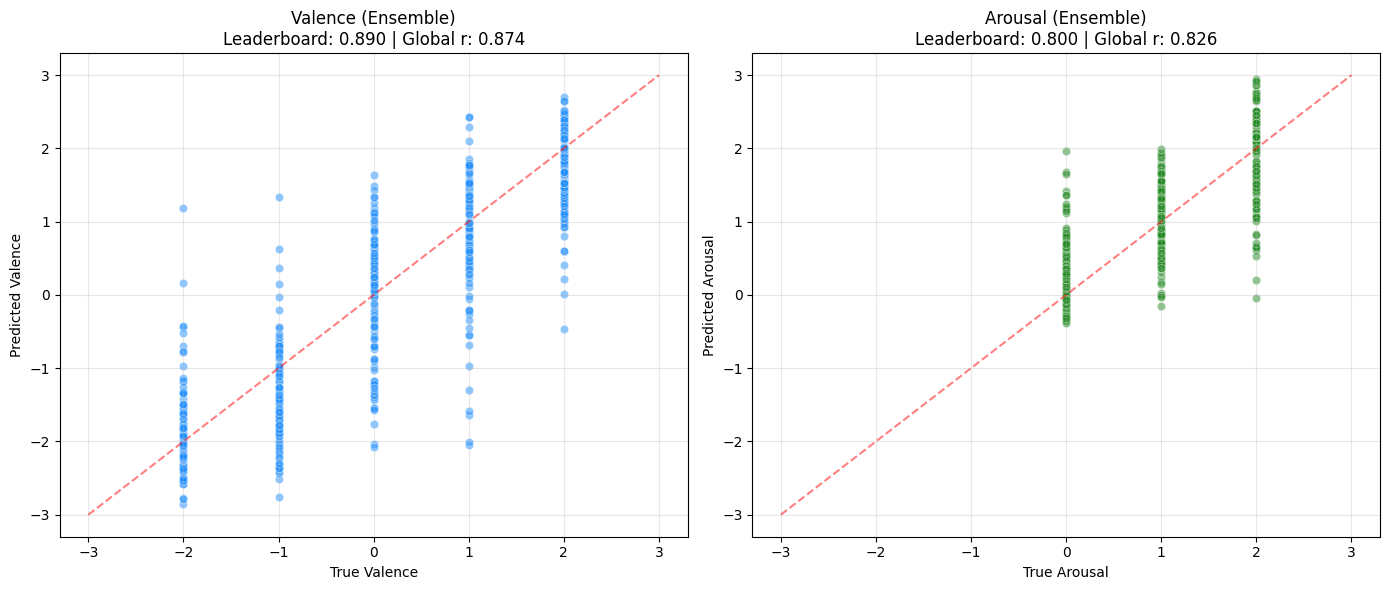


ENSEMBLE PERFORMANCE REPORT (5 Folds Averaged)
METRIC               | VALENCE         | AROUSAL         | AVERAGE        
-------------------------------------------------------------------------
Composite Score      | 0.8902          | 0.8004          | 0.8453         
Global Pearson r     | 0.8743          | 0.8262          | 0.8502         
MSE (Error)          | 0.5708          | 0.2394          | 0.4051         
MAE (Error)          | 0.5742          | 0.3650          | 0.4696         


In [136]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Valence Scatter
sns.scatterplot(x=trues[:, 0], y=ensemble_preds[:, 0], alpha=0.5, ax=ax[0], color='dodgerblue')
ax[0].plot([-3, 3], [-3, 3], 'r--', alpha=0.5)
ax[0].set_title(f'Valence (Ensemble)\nLeaderboard: {final_val_score:.3f} | Global r: {global_val_corr:.3f}')
ax[0].set_xlabel('True Valence')
ax[0].set_ylabel('Predicted Valence')
ax[0].grid(True, alpha=0.3)

# Arousal Scatter
sns.scatterplot(x=trues[:, 1], y=ensemble_preds[:, 1], alpha=0.5, ax=ax[1], color='forestgreen')
ax[1].plot([-3, 3], [-3, 3], 'r--', alpha=0.5)
ax[1].set_title(f'Arousal (Ensemble)\nLeaderboard: {final_arl_score:.3f} | Global r: {global_arl_corr:.3f}')
ax[1].set_xlabel('True Arousal')
ax[1].set_ylabel('Predicted Arousal')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"ENSEMBLE PERFORMANCE REPORT (5 Folds Averaged)")
print(f"{'='*60}")
print(f"{'METRIC':<20} | {'VALENCE':<15} | {'AROUSAL':<15} | {'AVERAGE':<15}")
print(f"{'-'*73}")
print(f"{'Composite Score':<20} | {final_val_score:<15.4f} | {final_arl_score:<15.4f} | {final_avg:<15.4f}")
print(f"{'Global Pearson r':<20} | {global_val_corr:<15.4f} | {global_arl_corr:<15.4f} | {(global_val_corr+global_arl_corr)/2:<15.4f}")
print(f"{'MSE (Error)':<20} | {val_mse:<15.4f} | {arl_mse:<15.4f} | {(val_mse+arl_mse)/2:<15.4f}")
print(f"{'MAE (Error)':<20} | {val_mae:<15.4f} | {arl_mae:<15.4f} | {(val_mae+arl_mae)/2:<15.4f}")
print(f"{'='*60}")

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
print("Best model loaded")


Best model loaded
